In [73]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tldextract
from urllib.parse import urlparse
from googlesearch import search


from imblearn.under_sampling import NearMiss

# **1. Import the dataset**

In [74]:
path = '../data/phishing_site_urls.csv'
phishing_data = pd.read_csv(path)
phishing_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [75]:
phishing_data['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

In [76]:
le = LabelEncoder()
phishing_data["Label"] = le.fit_transform(phishing_data["Label"])

In [77]:
phishing_data['Label'].value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [79]:
phishing_data.describe()

,Label
count,549346.000000
mean,0.715258
std,0.451292
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [80]:
phishing_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# **2. Feature extraction**

In [81]:
def letter_count(url):
    letters = []
    for i in url:
        if i.isalpha():
            letters.append(i)
    return letters


def digit_count(url):
    digits = []
    for i in url:
        if i.isnumeric():
            digits.append(i)
    return digits

def google_index(url):
    site = search(url, 5)
    return True if site else False

In [82]:
def extract_features(url):
    parsed_url = urlparse(url)
    # Extract domain features using tldextract
    domain_extract = tldextract.extract(url)
    domain = domain_extract.domain
    suffix = domain_extract.suffix
    letters = letter_count(url)
    digits = digit_count(url)
    google_searchable = google_index(url)

    # Features to extract
    features = {
        'url_length': len(url), #Length of URL
        'domain_length': len(domain), #Length of domain
        'dot_count': domain.count('.'), #Number of dots in the domain
        'is_ip_address': domain.replace('.', '').isdigit(), #IP address in the domain
        'special_chars_in_domain': any(char.isnumeric() or not char.isalnum() for char in domain), #Presence of special characters in the domain
        'tld_length': len(suffix), #Length of the top-level domain (e.g., '.com', '.org')
        'hyphen_in_domain': '-' in domain, #Presence of hyphen in the domain
        'at_symbol': '@' in parsed_url.netloc, #Presence of '@' in the URL
        'https': 'https' in parsed_url.scheme, #Check if site is secure with https
        'letter_count': len(letters), #Length of alphabets in url
        'digit_count': len(digits), #Length of numbers(digits) in url
        'google_search': google_searchable
    }

    return features

# **3. Data Preprocessing**

In [83]:
phishing_data['Label'].value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

From the above result, dataset is imbalanced. good class is almost twice the bad class. Let's undersample the good class since our dataset is large.

In [84]:
y_labels = phishing_data["Label"] 
phishing_data['Features'] = phishing_data["URL"].apply(extract_features) 
data_features = pd.json_normalize(phishing_data['Features'])
phishing_data = pd.concat([phishing_data, data_features], axis=1)
x_features = phishing_data.drop(["Label","URL","Features"], axis=1)

In [85]:
nm1 = NearMiss(version=1)
x_features, y_labels = nm1.fit_resample(x_features, y_labels)

In [86]:
x_features.to_csv('../data/x_features.csv')

In [87]:
y_labels.value_counts()

Label
0    156422
1    156422
Name: count, dtype: int64

In [88]:
x_features.head()

,url_length,domain_length,dot_count,is_ip_address,special_chars_in_domain,tld_length,hyphen_in_domain,at_symbol,https,letter_count,digit_count,google_search
0,225,6,0,False,False,2,False,False,False,135,58,True
1,81,7,0,False,False,3,False,False,False,65,1,True
2,177,12,0,False,False,3,False,False,False,111,47,True
3,60,9,0,False,False,3,False,False,False,52,0,True
4,116,15,0,False,False,3,False,False,False,82,21,True


In [89]:
phishing_data.isna().sum()

URL                        0
Label                      0
Features                   0
url_length                 0
domain_length              0
dot_count                  0
is_ip_address              0
special_chars_in_domain    0
tld_length                 0
hyphen_in_domain           0
at_symbol                  0
https                      0
letter_count               0
digit_count                0
google_search              0
dtype: int64

In [90]:
x_features.describe()

,url_length,domain_length,dot_count,tld_length,letter_count,digit_count
count,312844.000000,312844.000000,312844.000000,312844.000000,312844.000000,312844.000000
mean,47.580903,10.322592,0.074942,2.957011,36.858473,4.540356
std,53.889648,4.412560,0.468198,0.912409,37.026950,14.632241
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,7.000000,0.000000,3.000000,20.000000,0.000000
50%,34.000000,9.000000,0.000000,3.000000,28.000000,0.000000
75%,49.000000,13.000000,0.000000,3.000000,40.000000,2.000000
max,2307.000000,121.000000,3.000000,12.000000,2141.000000,545.000000


In [91]:
y_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [92]:
y_labels.value_counts()

Label
0    156422
1    156422
Name: count, dtype: int64

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size = 0.3, random_state = 42)

In [94]:

models = {'Logistic Regression': LogisticRegression(), 
          'Decision Tree': DecisionTreeClassifier(max_depth=2),
          'Random Forest': RandomForestClassifier(
              n_estimators=100, 
              max_depth=5, 
              min_samples_split=2, 
              min_samples_leaf=1, 
              max_features=None, 
              bootstrap=True, 
              n_jobs=-1)
          }

# **4. Model Training**

In [95]:
train_results = []
test_results = []

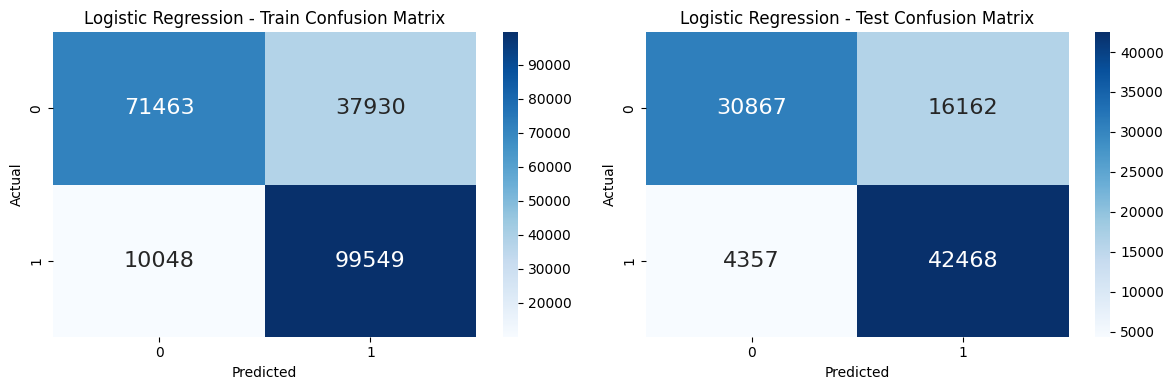

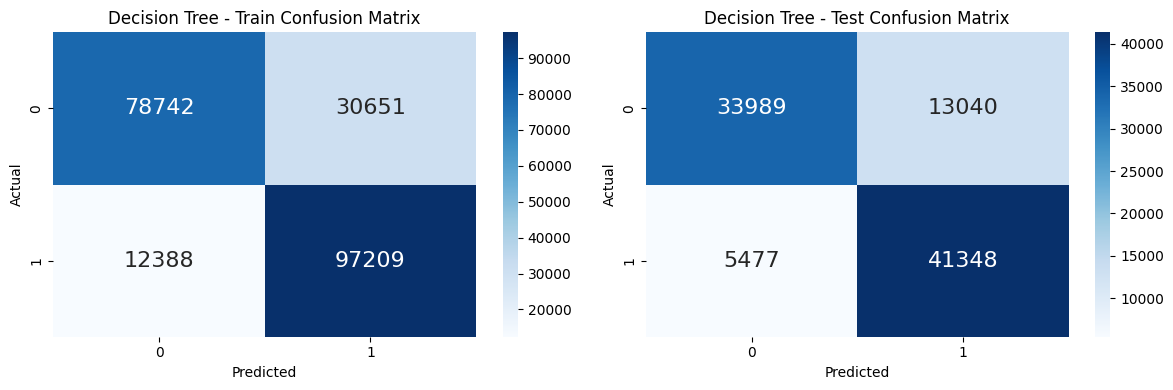

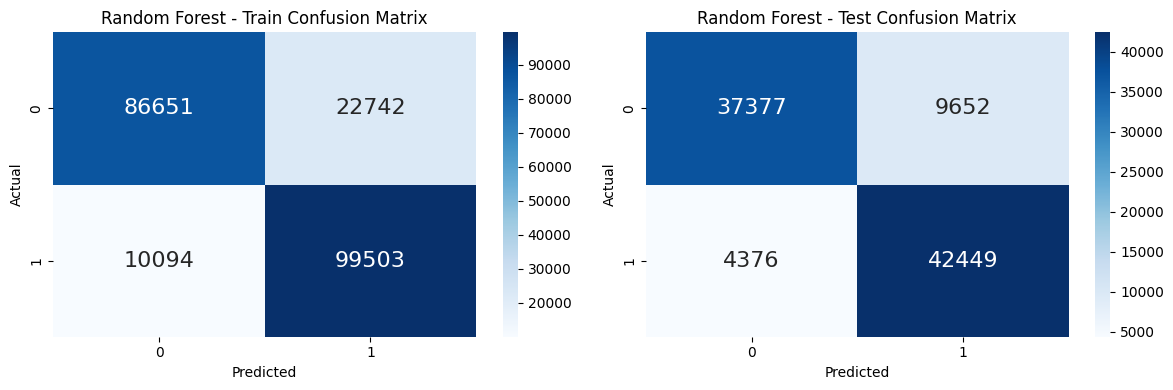

In [96]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    # Compute confusion matrices
    train_cm = confusion_matrix(y_train, y_train_predict)
    test_cm = confusion_matrix(y_test, y_test_predict)
    
    # Plot confusion matrices using Seaborn
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{name} - Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{name} - Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    train_report = classification_report(y_train, y_train_predict, output_dict=True)
    test_report = classification_report(y_test, y_test_predict, output_dict=True)
    train_results.append({'Machine Learning Model': name,
                    'Accuracy': round(train_report['accuracy'],3),
                    'Precision': round(train_report['weighted avg']['precision'],3),
                    'Recall': round(train_report['weighted avg']['recall'],3),
                    'F1 Score': round(train_report['weighted avg']['f1-score'],3),
                    'Support': round(train_report['weighted avg']['support'],3)})
    test_results.append({'Machine Learning Model': name,
                    'Accuracy': round(test_report['accuracy'],3),
                    'Precision': round(test_report['weighted avg']['precision'],3),
                    'Recall': round(test_report['weighted avg']['recall'],3),
                    'F1 Score': round(test_report['weighted avg']['f1-score'],3),
                    'Support': round(test_report['weighted avg']['support'],3)})

In [97]:
# Convert the results into DataFrames
train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

In [98]:
sorted_train_results = train_results.sort_values(by='Accuracy', ascending=False)
sorted_test_results = test_results.sort_values(by='Accuracy', ascending=False)
print(f'Training Data Report:\n {sorted_train_results}')
print(f'\nTesting Data Report:\n {sorted_test_results}')

Training Data Report:
   Machine Learning Model  Accuracy  Precision  Recall  F1 Score   Support
2          Random Forest     0.850      0.855   0.850     0.850  218990.0
1          Decision Tree     0.803      0.812   0.803     0.802  218990.0
0    Logistic Regression     0.781      0.800   0.781     0.777  218990.0

Testing Data Report:
   Machine Learning Model  Accuracy  Precision  Recall  F1 Score  Support
2          Random Forest     0.851      0.855   0.851     0.850  93854.0
1          Decision Tree     0.803      0.811   0.803     0.801  93854.0
0    Logistic Regression     0.781      0.800   0.781     0.778  93854.0


# **5. Model Comparison**
## 5.1. Metric Comparison 

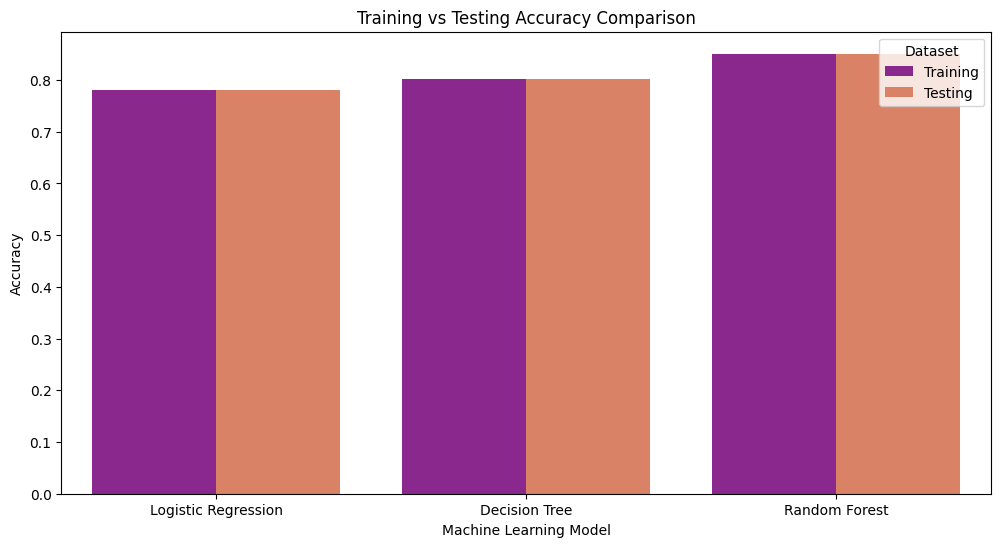

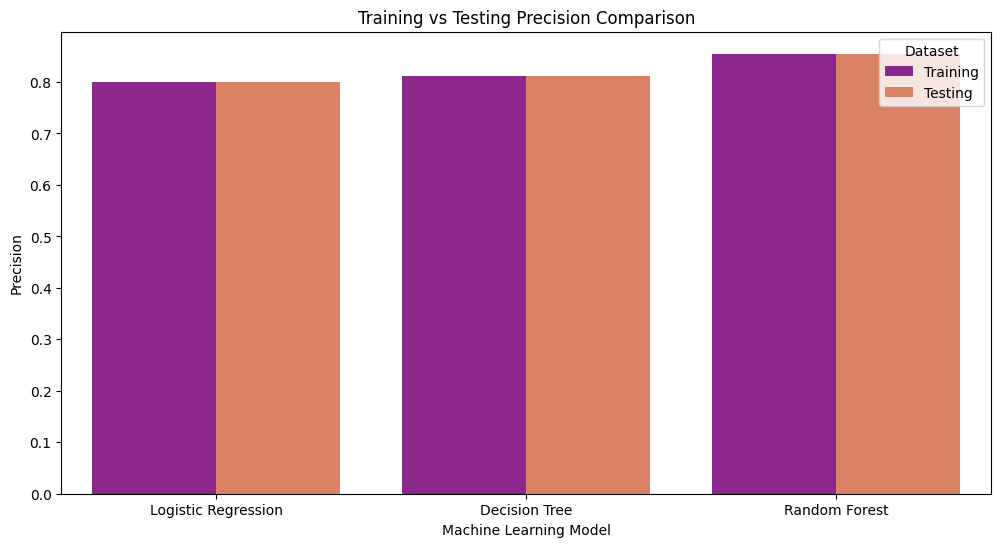

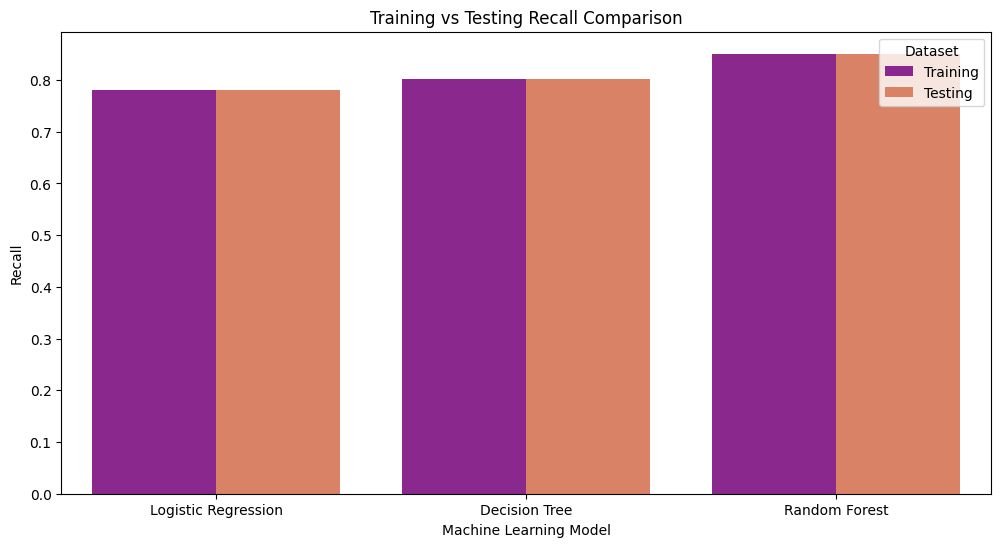

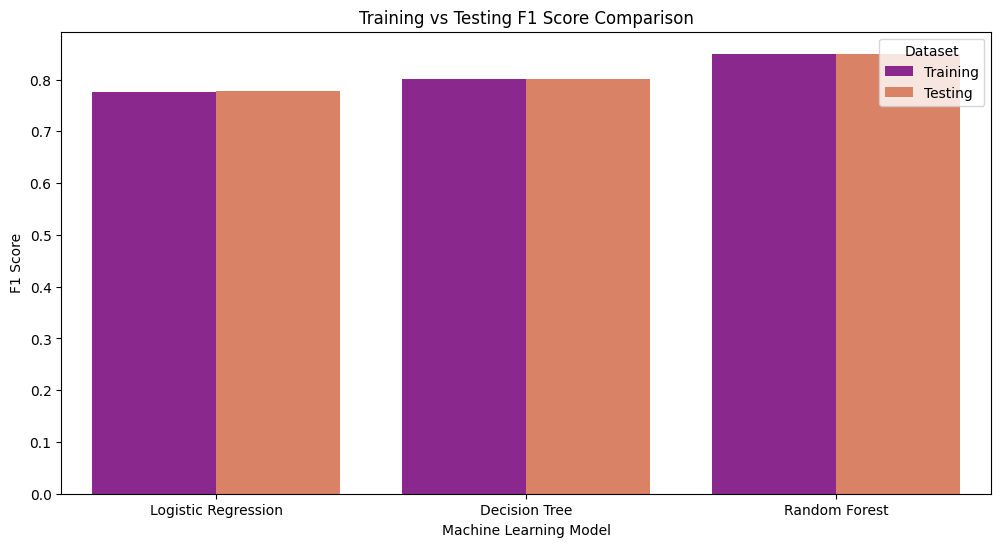

In [99]:
# Create a new column in training and testing DataFrames to define
train_results['Dataset'] = 'Training'
test_results['Dataset'] = 'Testing'
# Create a new DataFrame which is a concatenation of both sets
all_results = pd.concat([train_results, test_results], ignore_index = True)
#Remove the Support column from the DataFrame
results_without_support = all_results.drop('Support', axis=1, errors='ignore')
# Melt the DataFrame for easier plotting
results_melted = results_without_support.melt(id_vars=['Machine Learning Model', 'Dataset'], var_name='Metric', value_name='Score')

unique_metrics = results_melted['Metric'].unique()

for metric in unique_metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Machine Learning Model', 
                y='Score',
                data=results_melted[results_melted['Metric'] == metric],
                hue='Dataset',
                palette='plasma')
    plt.title(f'Training vs Testing {metric} Comparison')
    plt.xlabel('Machine Learning Model')
    plt.ylabel(metric)
    plt.show()

## 5.2. All Metrics

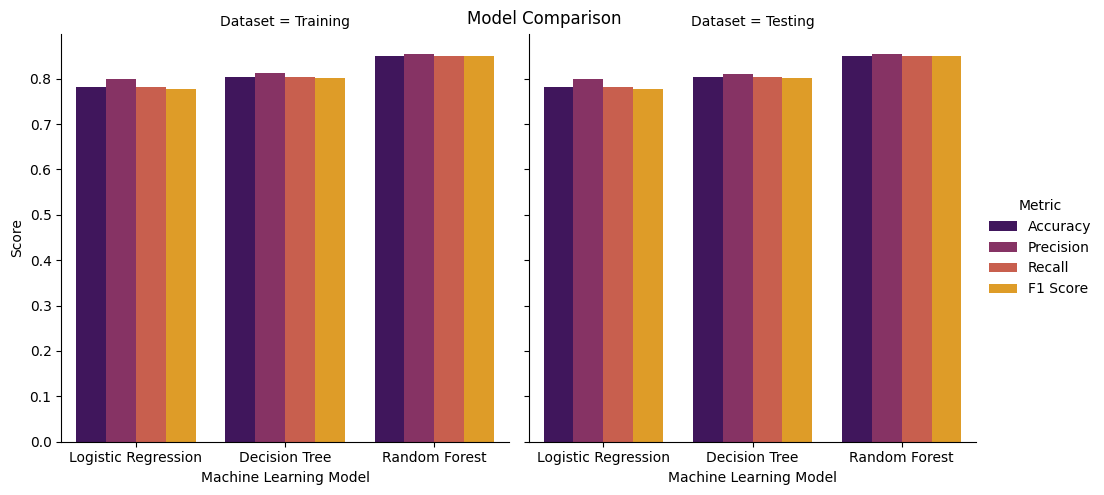

In [100]:
grid = sns.catplot(x='Machine Learning Model', 
            y='Score', 
            data=results_melted,
            hue='Metric',
            col='Dataset',
            errorbar=None,
            palette='inferno',
            kind='bar')
grid.fig.suptitle('Model Comparison')
grid.set_axis_labels('Machine Learning Model', 'Score')
plt.show()

# **6. Model Output**

In [101]:
import pickle
for name, model in models.items():
    name = name.replace(' ','_') + '.h5'
    with open(f'../trained_model/{name}','wb') as file:
        pickle.dump(model, file)